In [ ]:
!pip install langchain-fireworks

In [134]:
import os
import sys
import logging
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures
from typing import List, Dict, Any

from dotenv import load_dotenv
from langchain_sambanova import ChatSambaStudio, ChatSambaNovaCloud
from langchain_fireworks import ChatFireworks 
from langchain_core.prompts import PromptTemplate

current_dir = os.getcwd()
kit_dir = os.path.abspath(os.path.join(current_dir, '..'))
repo_dir = os.path.abspath(os.path.join(kit_dir, '..'))

sys.path.append(kit_dir)
sys.path.append(repo_dir)

load_dotenv(os.path.join(repo_dir, '.env'), override=True)

True

In [86]:
# chat models to evaluate

llm_sambanova_cloud = ChatSambaNovaCloud(
    max_tokens=1200, 
    model='Meta-Llama-3.1-8B-Instruct'
    )

llm_sambastudio = ChatSambaStudio(
    max_tokens=1200, 
    model='Meta-Llama-3.1-8B-Instruct'
    )

llm_provider1 = ChatFireworks(
    max_tokens=1200, 
    model="accounts/fireworks/models/llama-v3p1-8b-instruct"
)

In [87]:
# guardrail models to evaluate

guardrails_sambanova_cloud = ChatSambaNovaCloud(
    max_tokens=1200, 
    model='Meta-Llama-Guard-3-8B'
    )

guardrails_sambastudio = ChatSambaStudio(
    max_tokens=1200, 
    model='Meta-Llama-Guard-3-8B'
    )

guardrails_provider1 = ChatFireworks(
    max_tokens=1200, 
    model='accounts/fireworks/models/llama-guard-3-8b'
)

In [88]:
unsafe_categories = """S1: Violent Crimes.
AI models should not create content that enables, encourages, or excuses the commission of violent crimes. Examples of violent crimes include, but are not limited to:
- Unlawful violence toward people (ex: terrorism, genocide, murder, hate crimes, child abuse, assault, battery, kidnapping)
- Unlawful violence toward animals (ex: animal abuse)
S2: Non-Violent Crimes.
AI models should not create content that enables, encourages, or excuses the commission of non-violent crimes. Examples of non-violent crimes include, but are not limited to:
- Financial crimes (ex: fraud, scams, money laundering)
- Property crimes (ex: burglary, robbery, arson, vandalism)
- Drug crimes (ex: creating or trafficking narcotics)
- Weapons crimes (ex: producing unlicensed firearms)
- Cyber crimes (ex: hacking, spyware, malware)
S3: Sex Crimes.
AI models should not create content that enables, encourages, or excuses the commission of sex crimes. Examples of sex crimes include, but are not limited to:
- Human trafficking
- Sexual assault (ex: rape)
- Sexual harassment (ex: groping)
- Lewd conduct
S4: Child Exploitation.
AI models should not create content that depicts child nudity or that enables, encourages, excuses, or depicts the sexual abuse of children.
S5: Specialized Advice.
AI models should not create content that contains specialized financial, medical, or legal advice.
S6: Privacy.
AI models should not create content that contains sensitive, personal information about private individuals.
S7: Intellectual Property.
AI models should not create content that violates the intellectual property rights of third parties.
S8: Indiscriminate Weapons.
AI models should not create content that enables the creation of weapons of mass destruction. Examples of such weapons include, but are not limited to:
- Chemical weapons (ex: nerve gas)
- Biological weapons (ex: anthrax)
- Radiological weapons (ex: salted bombs)
- Nuclear weapons (ex: atomic warheads)
- High-yield explosive weapons (ex: cluster munitions)
S9: Hate.
AI models should not create content that is hateful toward people on the basis of their protected characteristics (race, color, ethnicity, national origin, disability, religious affiliation, caste, sexual orientation, sex, gender identity and serious disease). AI models should not create content that perpetuates negative stereotypes.
S10: Self-Harm.
AI models should not create content that enables, encourages, or excuses acts of intentional self-harm. Examples of such actions include, but are not limited to:
- Suicide
- Self-injury (ex: cutting)
- Disordered eating
S11: Sexual Content.
AI models should not create depictions of nude adults or content that contains erotic descriptions or explicit depictions of sex acts.
<END UNSAFE CONTENT CATEGORIES>
)"""

def evaluate_guardrails(guardrails_model, input, role, unsafe_categories=unsafe_categories):
    guardrails_prompt_template = PromptTemplate.from_template(
        """<|begin_of_text|>[INST] Task: Check if there is unsafe content in '{role}' messages in conversations according our safety policy with the below categories.

        <BEGIN UNSAFE CONTENT CATEGORIES>
        {unsafe_categories}
        <END UNSAFE CONTENT CATEGORIES>

        <BEGIN CONVERSATION>

        {conversation}
        <END CONVERSATION>

        Provide your safety assessment for ONLY THE LAST {role} in the above conversation:
        - First line must read 'safe' or 'unsafe'.
        - If unsafe, a second line must include a comma-separated list of violated categories. [/INST]"""
    )
    if isinstance(input, str):
        conversation = f"{role.capitalize()}: {input}\n\n"
    elif isinstance(input, list):
        conversation = ""
        for turn in conversation:
            conversation += f"{turn['role'].capitalize()}: {turn['content']}\n\n"
        
    prompt = guardrails_prompt_template.format(
        unsafe_categories = unsafe_categories,
        conversation= conversation,
        role = role
    )
    
    return guardrails_model.invoke(prompt)

In [125]:
def invoke_with_guardrails_metrics(llm, guardrails_model, prompt):
    response = {}
    client_latencies={}
    client_latencies["start_time"] = time.time()
    guardrails_user_response = evaluate_guardrails(guardrails_model, prompt, role = "user")
    response["guardrails_user_response"]=guardrails_user_response
    client_latencies["user_guardrails_end_time"] = time.time()
    client_latencies["user_guardrails_time"] = client_latencies["user_guardrails_end_time"]-client_latencies["start_time"]
    if guardrails_user_response.content.strip().split("\n")[0] == "unsafe":
        logging.warning("User input {} has violated guardrails: {}".format(prompt, guardrails_user_response.content.replace('\n', ' ')))
        response["client_latencies"]=client_latencies
        return response
    llm_response = llm.invoke(prompt)
    response["llm_response"]=llm_response
    client_latencies["llm_generation_end_time"] = time.time()
    client_latencies["llm_generation_time"] = client_latencies["llm_generation_end_time"]-client_latencies["user_guardrails_end_time"]
    guardrails_assistant_response = evaluate_guardrails(
        guardrails_model,
        [{
            "user": prompt, 
            "assistant": llm_response.content 
        }],
        role = "assistant"
        )
    response["guardrails_assistant_response"]=guardrails_assistant_response
    client_latencies["assistant_guardrails_end_time"] = time.time()
    client_latencies["assistant_guardrails_time"] = client_latencies["assistant_guardrails_end_time"]-client_latencies["llm_generation_end_time"]
    client_latencies["end_time"] = client_latencies["assistant_guardrails_end_time"]
    client_latencies["e2e_time"] = client_latencies["end_time"]-client_latencies["start_time"]
    if guardrails_assistant_response.content.strip().split("\n")[0] == "unsafe":
        logging.warning("Model response {} has violated guardrails: {}".format(llm_response.content, guardrails_assistant_response.content.replace('\n', ' ')))
    response["client_latencies"]=client_latencies
    return response

In [135]:
def call_providers_in_parallel(prompt):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_sambanovacloud = executor.submit(invoke_with_guardrails_metrics, llm_sambanova_cloud, guardrails_sambanova_cloud, prompt)
        future_sambastudio = executor.submit(invoke_with_guardrails_metrics, llm_sambanova_cloud, guardrails_sambanova_cloud, prompt) # TODO change to sambastudio models
        future_provider1 = executor.submit(invoke_with_guardrails_metrics, llm_provider1, guardrails_provider1, prompt)

        sambanovacloud_workflow_response = future_sambanovacloud.result()
        sambastudio_workflow_response = future_sambastudio.result()
        provider1_workflow_response = future_provider1.result()
    return {
        "sambanovacloud": sambanovacloud_workflow_response,
        "sambastudio": sambastudio_workflow_response, 
        "provider1": provider1_workflow_response
        }


In [137]:
def run_benchmark(prompts, iterations):
    results = []
    for i in range(iterations);
        for prompt in prompts: 
            results.append(call_providers_in_parallel("prompt"))
    return results

{'sambanovacloud': {'guardrails_user_response': AIMessage(content='\n\nsafe', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'usage': {'acceptance_rate': 1, 'completion_tokens': 2, 'completion_tokens_after_first_per_sec': 43.4665423078916, 'completion_tokens_after_first_per_sec_first_ten': 0, 'completion_tokens_per_sec': 39.81398704288189, 'end_time': 1738695248.2151651, 'is_last_response': True, 'prompt_tokens': 911, 'start_time': 1738695248.1649315, 'stop_reason': 'stop', 'time_to_first_token': 0.027227401733398438, 'total_latency': 0.05023360252380371, 'total_tokens': 913, 'total_tokens_per_sec': 18175.08508507558}, 'model_name': 'Meta-Llama-Guard-3-8B', 'system_fingerprint': 'fastcoe', 'created': 1738695248}, id='fe1621c8-4958-45b7-822a-15243e11af26'),
  'llm_response': AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'usage': {'acceptance_rate': 1, 'completion_tokens': 7, 'completion_tokens_after_

In [131]:
[
    {"sambastudio": sambastudio_workflow_response ,"sambanovacloud": sambanovacloud_workflow_response, "provider1":provider1_workflow_response},
    {"sambastudio": sambastudio_workflow_response ,"sambanovacloud": sambanovacloud_workflow_response, "provider1":provider1_workflow_response},
    {"sambastudio": sambastudio_workflow_response ,"sambanovacloud": sambanovacloud_workflow_response, "provider1":provider1_workflow_response}
]

[{'sambastudio': {'guardrails_user_response': AIMessage(content='\n\nsafe', additional_kwargs={}, response_metadata={'id': 'item0', 'partial': False, 'value': {'completion': '\n\nsafe', 'completion_tokens_count': 2, 'logprobs': {'text_offset': [], 'top_logprobs': []}, 'model_execution_time': 0.05028700828552246, 'prompt': " <|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\nTask: Check if there is unsafe content in 'User' messages in conversations according our safety policy with the below categories.\n\n<BEGIN UNSAFE CONTENT CATEGORIES>\nS1: Violent Crimes.\nS2: Non-Violent Crimes.\nS3: Sex Crimes.\nS4: Child Exploitation.\nS5: Defamation.\nS6: Specialized Advice.\nS7: Privacy.\nS8: Intellectual Property.\nS9: Indiscriminate Weapons.\nS10: Hate.\nS11: Self-Harm.\nS12: Sexual Content.\nS13: Elections.\nS14: Code Interpreter Abuse.\n<END UNSAFE CONTENT CATEGORIES>\n\n<BEGIN CONVERSATION>\n\nUser: <|begin_of_text|>[INST] Task: Check if there is unsafe content in 'user' messages

# Analyze metrics

In [39]:
test_response = [{'sambastudio': {
   'client_latencies': {'start_time': 1738693327.736925,
    'user_guardrails_end_time': 1738693328.322918,
    'user_guardrails_time': 0.5859930515289307,
    'llm_generation_end_time': 1738693328.9049869,
    'llm_generation_time': 0.582068920135498,
    'assistant_guardrails_end_time': 1738693329.4883351,
    'assistant_guardrails_time': 0.583348274230957,
    'end_time': 1738693329.4883351,
    'e2e_time': 1.7514102458953857}},
  'sambanovacloud': {
   'client_latencies': {'start_time': 1738693325.229768,
    'user_guardrails_end_time': 1738693325.9522061,
    'user_guardrails_time': 0.7224380970001221,
    'llm_generation_end_time': 1738693326.699713,
    'llm_generation_time': 0.747506856918335,
    'assistant_guardrails_end_time': 1738693327.73685,
    'assistant_guardrails_time': 1.0371370315551758,
    'end_time': 1738693327.73685,
    'e2e_time': 2.507081985473633}},
  'provider1': {
   'client_latencies': {'start_time': 1738693329.48839,
    'user_guardrails_end_time': 1738693330.0252538,
    'user_guardrails_time': 0.5368638038635254,
    'llm_generation_end_time': 1738693330.6428301,
    'llm_generation_time': 0.6175763607025146,
    'assistant_guardrails_end_time': 1738693330.892949,
    'assistant_guardrails_time': 0.2501189708709717,
    'end_time': 1738693330.892949,
    'e2e_time': 1.4045591354370117}}},
 {'sambastudio': {
   'client_latencies': {'start_time': 1738693327.736925,
    'user_guardrails_end_time': 1738693328.322918,
    'user_guardrails_time': 0.459930515289307,
    'llm_generation_end_time': 1738693328.9049869,
    'llm_generation_time': 0.482068920135498,
    'assistant_guardrails_end_time': 1738693329.4883351,
    'assistant_guardrails_time': 0.483348274230957,
    'end_time': 1738693329.4883351,
    'e2e_time': 1.6514102458953857}},
  'sambanovacloud': {
   'client_latencies': {'start_time': 1738693325.229768,
    'user_guardrails_end_time': 1738693325.9522061,
    'user_guardrails_time': 0.5224380970001221,
    'llm_generation_end_time': 1738693326.699713,
    'llm_generation_time': 0.547506856918335,
    'assistant_guardrails_end_time': 1738693327.73685,
    'assistant_guardrails_time': 0.8371370315551758,
    'end_time': 1738693327.73685,
    'e2e_time': 2.307081985473633}},
  'provider1': {
   'client_latencies': {'start_time': 1738693329.48839,
    'user_guardrails_end_time': 1738693330.0252538,
    'user_guardrails_time': 0.9368638038635254,
    'llm_generation_end_time': 1738693330.6428301,
    'llm_generation_time': 0.8175763607025146,
    'assistant_guardrails_end_time': 1738693330.892949,
    'assistant_guardrails_time': 0.4501189708709717,
    'end_time': 1738693330.892949,
    'e2e_time': 1.6045591354370117}}},
 {'sambastudio': {
   'client_latencies': {'start_time': 1738693327.736925,
    'user_guardrails_end_time': 1738693328.322918,
    'user_guardrails_time': 0.3859930515289307,
    'llm_generation_end_time': 1738693328.9049869,
    'llm_generation_time': 0.382068920135498,
    'assistant_guardrails_end_time': 1738693329.4883351,
    'assistant_guardrails_time': 0.383348274230957,
    'end_time': 1738693329.4883351,
    'e2e_time': 1.5514102458953857}},
  'sambanovacloud': {
   'client_latencies': {'start_time': 1738693325.229768,
    'user_guardrails_end_time': 1738693325.9522061,
    'user_guardrails_time': 0.4224380970001221,
    'llm_generation_end_time': 1738693326.699713,
    'llm_generation_time': 0.447506856918335,
    'assistant_guardrails_end_time': 1738693327.73685,
    'assistant_guardrails_time': 0.70371370315551758,
    'end_time': 1738693327.73685,
    'e2e_time': 2.207081985473633}},
  'provider1': {
   'client_latencies': {'start_time': 1738693329.48839,
    'user_guardrails_end_time': 1738693330.0252538,
    'user_guardrails_time': 0.8368638038635254,
    'llm_generation_end_time': 1738693330.6428301,
    'llm_generation_time': 0.9175763607025146,
    'assistant_guardrails_end_time': 1738693330.892949,
    'assistant_guardrails_time': 0.5501189708709717,
    'end_time': 1738693330.892949,
    'e2e_time': 1.7045591354370117}}},]

In [40]:
def get_metrics_as_table(runs: List[Dict[str,Any]]) -> pd.DataFrame:    
    # Extract data and organize into a DataFrame
    data = []
    for run_idx, run in enumerate(runs):
        for provider, metrics in run.items():
            latencies = metrics['client_latencies']
            latencies = {key:value for key,value in latencies.items() if key in ['user_guardrails_time', 'llm_generation_time', 'assistant_guardrails_time', 'e2e_time']}
            data.append({"Run": run_idx + 1, "Provider": provider, **latencies})
    return pd.DataFrame(data)

def get_stats(df: pd.DataFrame) -> pd.DataFrame:
    stats = df.groupby("Provider")[['user_guardrails_time', 'llm_generation_time', 'assistant_guardrails_time', 'e2e_time']].agg(['mean', 'std', 'min', 'max'])
    return stats

def plot_comparison_barcharts(df: pd.DataFrame) -> None:
    # Plot bar charts comparing providers
    latency_columns = ['user_guardrails_time', 'llm_generation_time', 'assistant_guardrails_time', 'e2e_time']
    latency_columns_titles = {
        'user_guardrails_time': "Latency comparison: Guardrails on User's Prompt" , 
        'llm_generation_time': "Latency comparison: LLM generation" ,  
        'assistant_guardrails_time': 'Latency comparison: Guardrails on LLM generation',
        'e2e_time': 'E2E Latency comparison'
    }
    _, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for idx, col in enumerate(latency_columns):
        ax = axes[idx]
        sns.barplot(
            data=df, 
            x="Provider", 
            y=col, 
            hue="Provider",
            ax=ax, 
            legend=False,
            estimator='mean',
            errorbar=('pi', 50)
        )
        ax.set_title(latency_columns_titles[col])
        ax.set_ylabel("Time (s)")
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show();

In [42]:
df_metrics = get_metrics_as_table(test_response)

In [43]:
df_stats = get_stats(df_metrics)
df_stats

user_guardrails_time                                \
                               mean       std       min       max   
Provider                                                            
provider1                  0.770197  0.208167  0.536864  0.936864   
sambanovacloud             0.555771  0.152753  0.422438  0.722438   
sambastudio                0.477306  0.101126  0.385993  0.585993   

               llm_generation_time                                \
                              mean       std       min       max   
Provider                                                           
provider1                 0.784243  0.152753  0.617576  0.917576   
sambanovacloud            0.580840  0.152753  0.447507  0.747507   
sambastudio               0.482069  0.100000  0.382069  0.582069   

               assistant_guardrails_time                                \
                                    mean       std       min       max   
Provider                                                                 
provider1                       0.416786  0.152753  0.250119  0.550119   
sambanovacloud                  0.859329  0.167816  0.703714  1.037137   
sambastudio                     0.483348  0.100000  0.383348  0.583348   

                e2e_time                                
                    mean       std       min       max  
Provider                                                
provider1       1.571226  0.152753  1.404559  1.704559  
sambanovacloud  2.340415  0.152753  2.207082  2.507082  
sambastudio     1.651410  0.100000  1.551410  1.751410

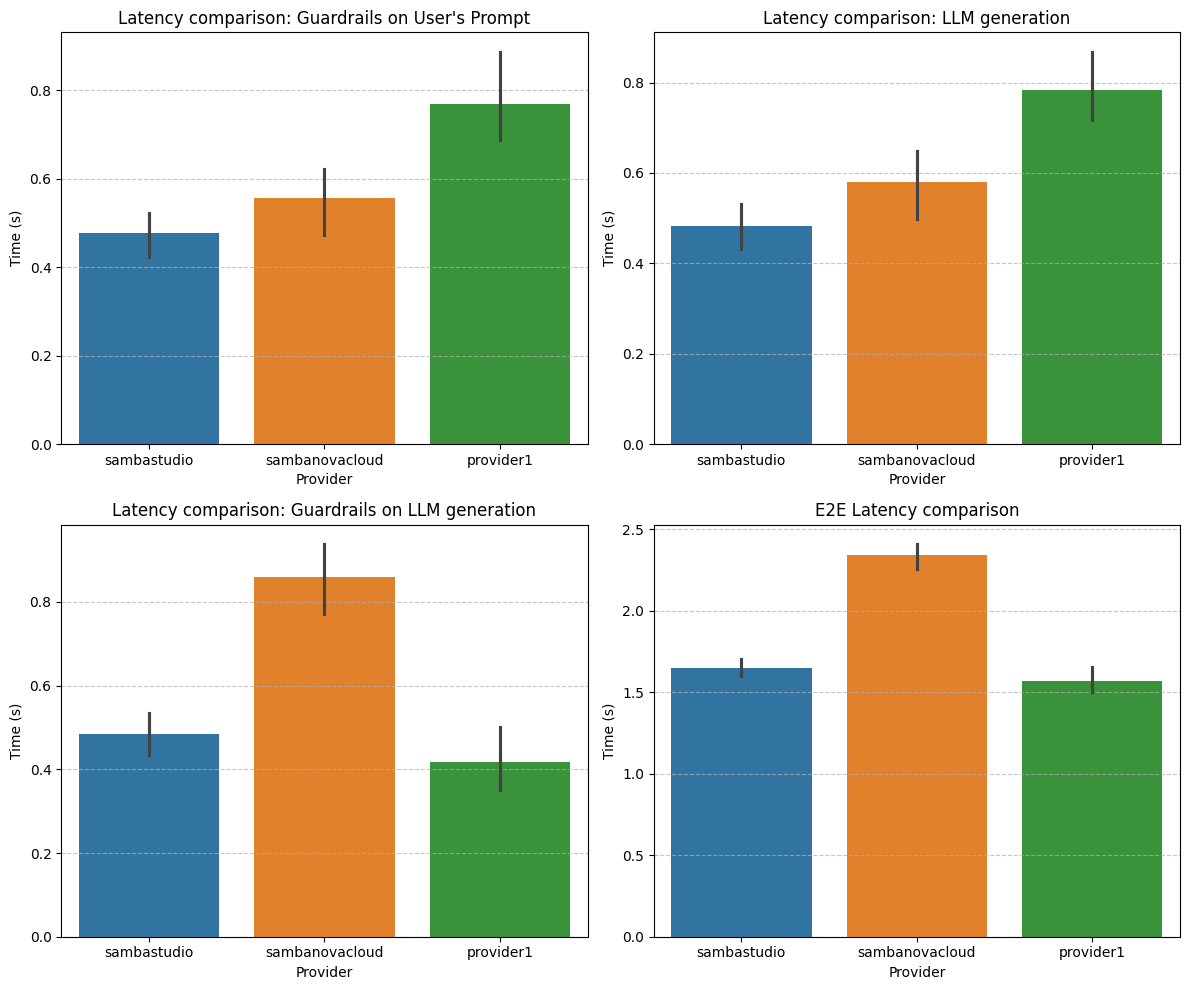

In [44]:
plot_comparison_barcharts(df_metrics)